In [1]:
folder_id = "1QPHknNg-CiKVVOjObRVaRnUA1I-GlL4H"

In [ ]:
!pip install -r requirements.txt

In [50]:
import gdown

In [ ]:
gdown.download_folder(id=folder_id)

In [1]:
import cv2

video_path = "data/parking_crop.mp4"


In [8]:
import matplotlib.pyplot as plt

In [5]:
cap = cv2.VideoCapture(video_path)

plt.figure(figsize=(4,4))

ret = True
c = 0
while ret:
    ret,imarr=cap.read()
    if c%10 == 0:
        plt.imshow(cv2.cvtColor(imarr,cv2.COLOR_BGR2RGB))
        plt.show()
    c = c  + 1

In [15]:
!wget https://raw.githubusercontent.com/computervisioneng/parking-space-counter/master/mask_crop.png

--2023-08-24 12:43:04--  https://raw.githubusercontent.com/computervisioneng/parking-space-counter/master/mask_crop.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8185 (8.0K) [image/png]
Saving to: ‘mask_crop.png’

mask_crop.png       100%[===================>]   7.99K  --.-KB/s    in 0s      

2023-08-24 12:43:04 (34.4 MB/s) - ‘mask_crop.png’ saved [8185/8185]



In [16]:
imarr  = cv2.imread("mask_crop.png",0) 

In [17]:
imarr.shape

(453, 381)

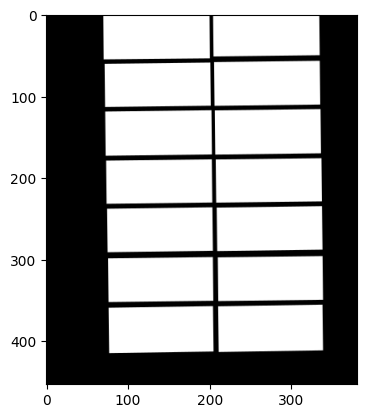

In [18]:
plt.imshow(imarr,cmap="gray")

In [20]:
connected_components = cv2.connectedComponentsWithStats(imarr, 4, cv2.CV_32S)

In [58]:
import pickle

from skimage.transform import resize
import numpy as np
import cv2


EMPTY = True
NOT_EMPTY = False

model_id = "1lilB79K-29TUbvbYbzQxYsKzAgC3_Xv6"
gdown.download(id=model_id)

MODEL = pickle.load(open("model.p", "rb"))


def empty_or_not(spot_bgr):

    flat_data = []

    img_resized = resize(spot_bgr, (15, 15, 3))
    flat_data.append(img_resized.flatten())
    flat_data = np.array(flat_data)

    y_output = MODEL.predict(flat_data)

    if y_output == 0:
        return "EMPTY"
    
    return "NOT_EMPTY"


def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components

    slots = []
    coef = 1
    for i in range(1, totalLabels):

        # Now extract the coordinate points
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)

        slots.append([x1, y1, w, h])

    return slots


In [47]:
all_boxes = get_parking_spots_bboxes(connected_components)

In [80]:
### to test big  frames

!wget https://raw.githubusercontent.com/computervisioneng/parking-space-counter/master/mask_1920_1080.png -O "mask_big.png"

--2023-08-24 14:05:15--  https://raw.githubusercontent.com/computervisioneng/parking-space-counter/master/mask_1920_1080.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114048 (111K) [image/png]
Saving to: ‘mask_big.png’

mask_big.png        100%[===================>] 111.38K  --.-KB/s    in 0.003s  

2023-08-24 14:05:16 (37.7 MB/s) - ‘mask_big.png’ saved [114048/114048]



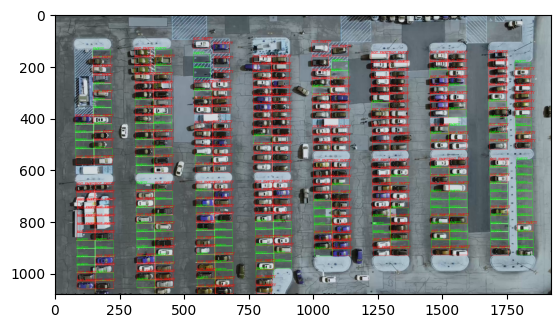

In [86]:
cap = cv2.VideoCapture("data/parking_1920_1080_loop.mp4")

# plt.figure(figsize=(4,4))

all_solts =  { i:[] for i in ["NOT_EMPTY","EMPTY"]}

imarr  = cv2.imread("mask_big.png",0) 
connected_components = cv2.connectedComponentsWithStats(imarr, 4, cv2.CV_32S)
all_boxes = get_parking_spots_bboxes(connected_components)
ret = True
c = 0
frame = 30
while ret:
    ret,imarr=cap.read()
    if c%frame == 0:
        if ret:
            c = c  + 1
            for box in all_boxes:
                x1,y1,w,h = box
                label = empty_or_not(imarr[y1:y1 + h,x1:x1 + w])
                if label == "NOT_EMPTY":
                    all_solts[label].append(1)
                    cv2.rectangle(imarr,(x1,y1),(x1 + w,y1 + h),(255,0,0),1)
                    cv2.putText(imarr,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.4,(255,0,0),1)
                else:
                    all_solts[label].append(1)
                    cv2.rectangle(imarr,(x1,y1),(x1 + w,y1 + h),(0,255,0),1)
                    cv2.putText(imarr,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.4,(0,255,0),1)
            
            cv2.putText(imarr,f" #total slots: {len(all_boxes)} #parking_area : { len(all_solts['EMPTY']) } #no_parking_area : {len(all_solts['NOT_EMPTY'])}",
            (0,1100),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,0),2)
            plt.imshow(imarr)
            plt.show